In [5]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns
from scipy import sparse

In [29]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'TL':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',
 'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#808080',
 'Unknown':'#000000',
 'Low_Quality_RNA':'#808080'}

In [ ]:
import sys 
from deepscore import deepscore

In [7]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('7', '7'), color_map='gist_earth')

In [9]:
adata = sc.read('objects/gene_activity_from_RNA.h5ad')

In [11]:
adata.X = sparse.csr_matrix(adata.X)

In [12]:
adata.var_names_make_unique()

In [13]:
adata

AnnData object with n_obs × n_vars = 75013 × 16787
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nucleosome_signal', 'tss_score', 'leiden'
    var: 'gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'protein_id'
    uns: 'leiden', 'leiden_colors', 'lsi', 'neighbors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_lsi_harmonized', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
ref_py = sc.read('../RNA/objects/Integration_scVI_Final.h5ad')
print(ref_py.shape,adata.shape)
# ref_py.var['ENSG'] = ref_py.var.index.copy()
# ref_py.var.index = ref_py.var['feature_name'].copy()
# ref_py.layers['counts'] = ref_py.raw.X.copy()
ref_py.X = ref_py.layers['counts'].copy()

In [ ]:
adata_rna = sc.read('../RNA/objects/Integration_scVI_Final.h5ad')
adata_rna = adata[adata.obs['batch'].isin(['snRNA'])]
adata_rna.index = [i.replace('-snRNA','') for i in adata_rna.index]
adata_rna = adata_rna[adata_rna.obs.index.isin(adata.obs.index)][adata[adata.obs.index.isin(adata_rna.obs.index)].obs.index]
adata = adata[adata.obs.index.isin(adata_rna.obs.index)]
adata.obs['Deepscore_external_RNA'] = adata_rna.obs['Deepscore_external']

In [15]:
ref_py = ref_py[:,ref_py.var.index.isin(adata.var_names)].copy()

In [33]:
ref_py.var_names

Index(['ADGRA2', 'MINDY4', 'SLC22A15', 'PAG1', 'CHD2', 'ARAP2', 'MYO3A',
       'SEMA4D', 'RAP1B', 'FBXL2',
       ...
       'UBE2G1', 'BRAF', 'NLGN4X', 'NR2F1', 'UBAP1', 'RPS4X', 'CARD11',
       'PRKDC', 'RAPGEF6', 'MICAL3'],
      dtype='object', length=3000)

In [ ]:
sc.pp.normalize_total(ref_py, target_sum=1e4)
sc.pp.log1p(ref_py)

# Identify differentially expressed genes between cell types
sc.tl.rank_genes_groups(ref_py, 'Deepscore_external', method='wilcoxon', use_raw=False)
selected_markers = set()
marker_dict = {}


In [ ]:
for cell_type in ref_py.obs['Deepscore_external'].unique():
    cell_type_markers = []
    for marker in ref_py.uns['rank_genes_groups']['names'][cell_type]:
        if marker not in selected_markers:
            cell_type_markers.append(marker)
            selected_markers.add(marker)
        if len(cell_type_markers) == 200:
            break
    marker_dict[cell_type] = cell_type_markers

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:

# Subset the data to the selected markers
ref_py = ref_py[:, list(selected_markers)]
adata = adata[:, list(selected_markers)]

In [21]:
sc.pp.scale(ref_py)
sc.pp.scale(adata)

In [ ]:
import tensorflow as tf



def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


n_feat = ref_py.shape[1]
n_labs = len(ref_py.obs['Deepscore_external'].cat.categories)

ds = deepscore.DeepScore(hidden_nodes=[256, 128, 64],
               n_features=n_feat, 
               n_labels=n_labs,
               epochs=30,
               batch_size=32, 
               activation="relu", 
               dropout=True, 
               dropout_rate=0.5,
               batchnorm=True, 
               lr=0.001,
               weight_reg=True)

ds.set_reference(ref_py, label_by='celltype', test_prop=0.2)



ds.train(earlystopping=True, patience=10, lr_scheduler=scheduler)
ds.model.save(f'models/deepscore')


adata = ds.annotate(adata, pred_key='Deepscore_internal')


sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

adata.write(f'objects/Deepscore_bySample/gene_activity_RNA_Deepscore.h5ad', compression = 'gzip')

2023-05-22 16:52:20.915078: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-22 16:52:20.916245: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:52:20.919858: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "deepscore"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3000)              12000     
_________________________________________________________________
dense256 (Dense)             (None, 256)               768256    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense128 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               51

2023-05-22 16:52:21.481816: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-22 16:52:21.481841: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-22 16:52:21.482269: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-22 16:52:21.732987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-22 16:52:21.751879: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/30
   7/1415 [..............................] - ETA: 39s - loss: 3.3167 - categorical_accuracy: 0.0579  

2023-05-22 16:52:23.248078: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-22 16:52:23.248106: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-22 16:52:23.263220: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-22 16:52:23.268465: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-22 16:52:23.274769: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./deepscore_logs/train/plugins/profile/2023_05_22_16_52_23
2023-05-22 16:52:23.277006: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./deepscore_logs/train/plugins/profile/2023_05_22_16_52_23/IJC20724.trace.json.gz
2023-05-22 16:52:23.300601: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./deepscore_logs/train/plugins/profile/2023_05_22_16_52_23

1415/1415 [==============================] - 44s 30ms/step - loss: 1.0836 - categorical_accuracy: 0.6873 - val_loss: 0.1121 - val_categorical_accuracy: 0.9704
Epoch 2/30
1415/1415 [==============================] - 40s 28ms/step - loss: 0.2968 - categorical_accuracy: 0.9198 - val_loss: 0.1002 - val_categorical_accuracy: 0.9728
Epoch 3/30
1415/1415 [==============================] - 52s 36ms/step - loss: 0.2358 - categorical_accuracy: 0.9368 - val_loss: 0.0970 - val_categorical_accuracy: 0.9740
Epoch 4/30
1415/1415 [==============================] - 48s 34ms/step - loss: 0.2079 - categorical_accuracy: 0.9453 - val_loss: 0.1091 - val_categorical_accuracy: 0.9694
Epoch 5/30
1415/1415 [==============================] - 47s 33ms/step - loss: 0.2001 - categorical_accuracy: 0.9472 - val_loss: 0.1048 - val_categorical_accuracy: 0.9696
Epoch 6/30
1415/1415 [==============================] - 60s 42ms/step - loss: 0.1857 - categorical_accuracy: 0.9484 - val_loss: 0.1130 - val_categorical_accuracy

2023-05-22 17:05:14.690936: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/deepscore/assets


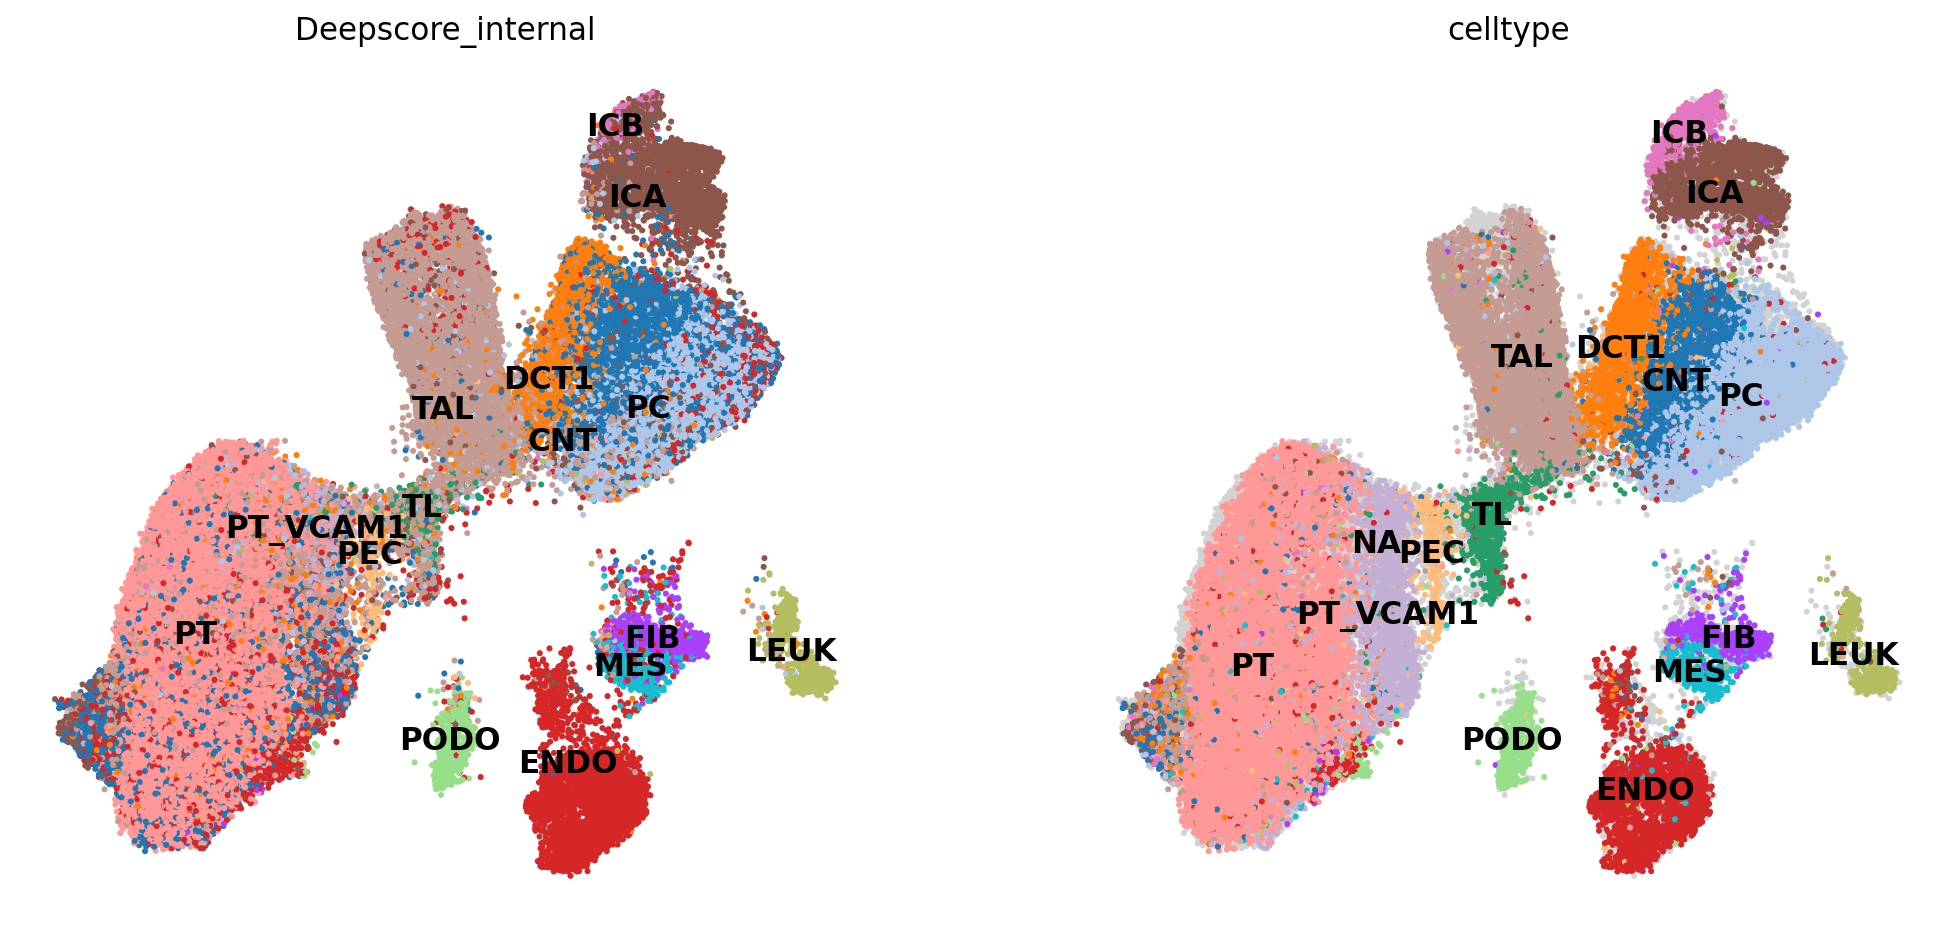

In [32]:

sc.pl.umap(adata, color = ['Deepscore_internal','celltype'], legend_loc='on data', frameon = False, size = 30, palette = palette)


In [38]:
adata[adata.obs.index.isin(ref_py.obs.index)]


View of AnnData object with n_obs × n_vars = 42510 × 3000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nucleosome_signal', 'tss_score', 'leiden', 'Deepscore_internal', 'celltype'
    var: 'gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'protein_id', 'mean', 'std'
    uns: 'leiden', 'lsi', 'neighbors', 'rank_genes_groups', 'sample_colors', 'umap', 'log1p', 'pca', 'Deepscore_internal_colors', 'celltype_colors'
    obsm: 'X_lsi', 'X_lsi_harmonized', 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

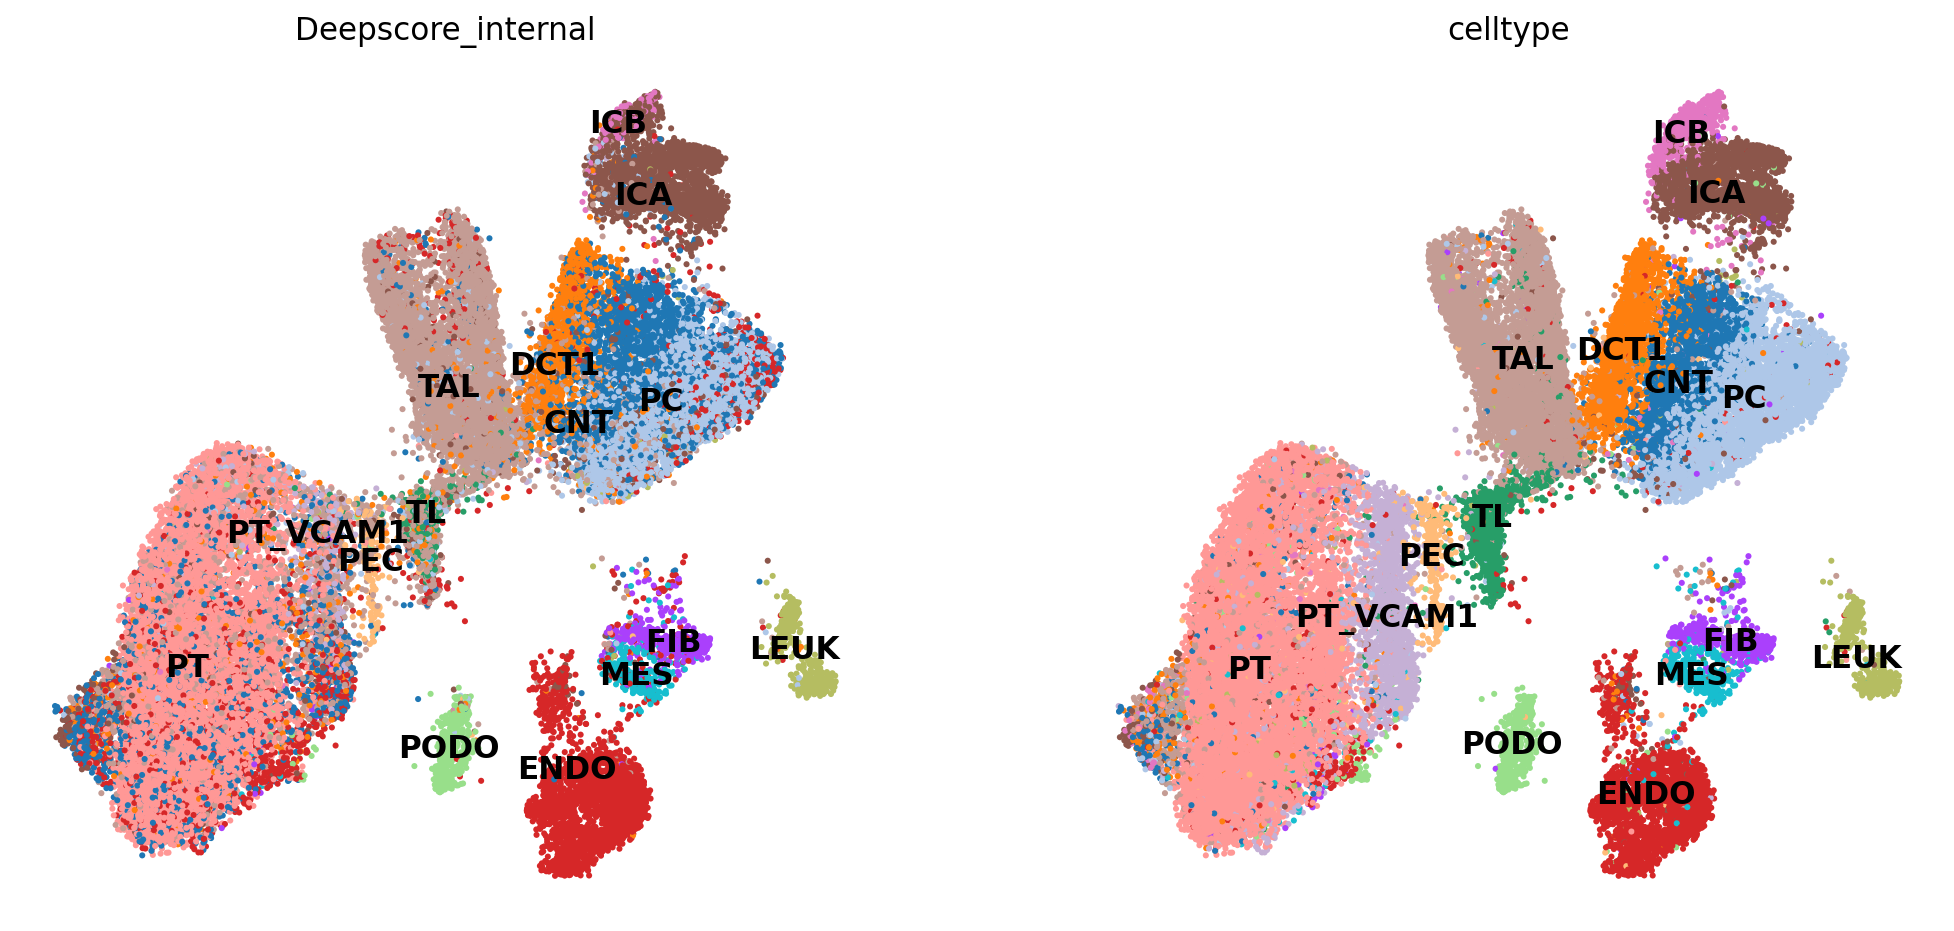

In [39]:

sc.pl.umap(adata[adata.obs.index.isin(ref_py.obs.index)], color = ['Deepscore_internal','celltype'], legend_loc='on data', frameon = False, size = 30, palette = palette)

In [60]:
sample_color_dic = {'lib_09': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lib_10': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'lib_15': (1.0, 0.4980392156862745, 0.054901960784313725),
 'lib_23': (1.0, 0.7333333333333333, 0.47058823529411764),
 'lib_29': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'lib_34': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'lib_36': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'lib_38': (1.0, 0.596078431372549, 0.5882352941176471),
 'lib_51': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'lib_54': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'lib_55': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'lib_56': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'lib_57': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

def comparison_heatmap(adata, key1, key2, label_1=None, label_2=None, cmap = 'Reds', annot = True, figsize=(7,7)):
    if label_1==None:
        label_1=key1
    if label_2==None:
        label_2=key2
    expected_df = adata.obs[[key1,key2]].groupby(by=[key2,key1]).size().reset_index(name = 'count')
    counts = np.array(expected_df['count'].tolist())
    df = pd.DataFrame(counts.reshape(((len(adata.obs[key2].cat.categories),len(adata.obs[key1].cat.categories)))), index = expected_df[key2].unique(), columns = expected_df[key1].unique())
    df = df[df.index]

    if annot ==True:
        annot_ = df.astype(int)
        sc.settings.set_figure_params(figsize=figsize, color_map='gist_earth')
    else:
        annot_=None
        sc.settings.set_figure_params(figsize=figsize, color_map='gist_earth')
    s = sns.heatmap(df/np.sum(df,axis = 0), cbar_kws={'label': '% cell shared between annotations'}, cmap=cmap, vmax=1, vmin=0, annot = annot_,  fmt='.7g')
    s.set_ylabel(label_2, fontsize=12)
    s.set_xlabel(label_1, fontsize = 12)
    return df

def n_cells_histogram(adata, sample_key='sample', sample_color_dic = sample_color_dic):
    df = pd.DataFrame(adata.obs[sample_key].value_counts().index, index = adata.obs[sample_key].value_counts().index  , columns =[ sample_key ])
    df['n_cells'] = adata.obs[sample_key].value_counts().values.astype(int)
    df.reindex(index=np.argsort(df['n_cells']).index.tolist()[::-1]).plot(kind='bar', x = sample_key, y ='n_cells', color = [sample_color_dic[i] for i in np.argsort(df['n_cells']).index.tolist()[::-1]], title = 'Total nº of Cells' )

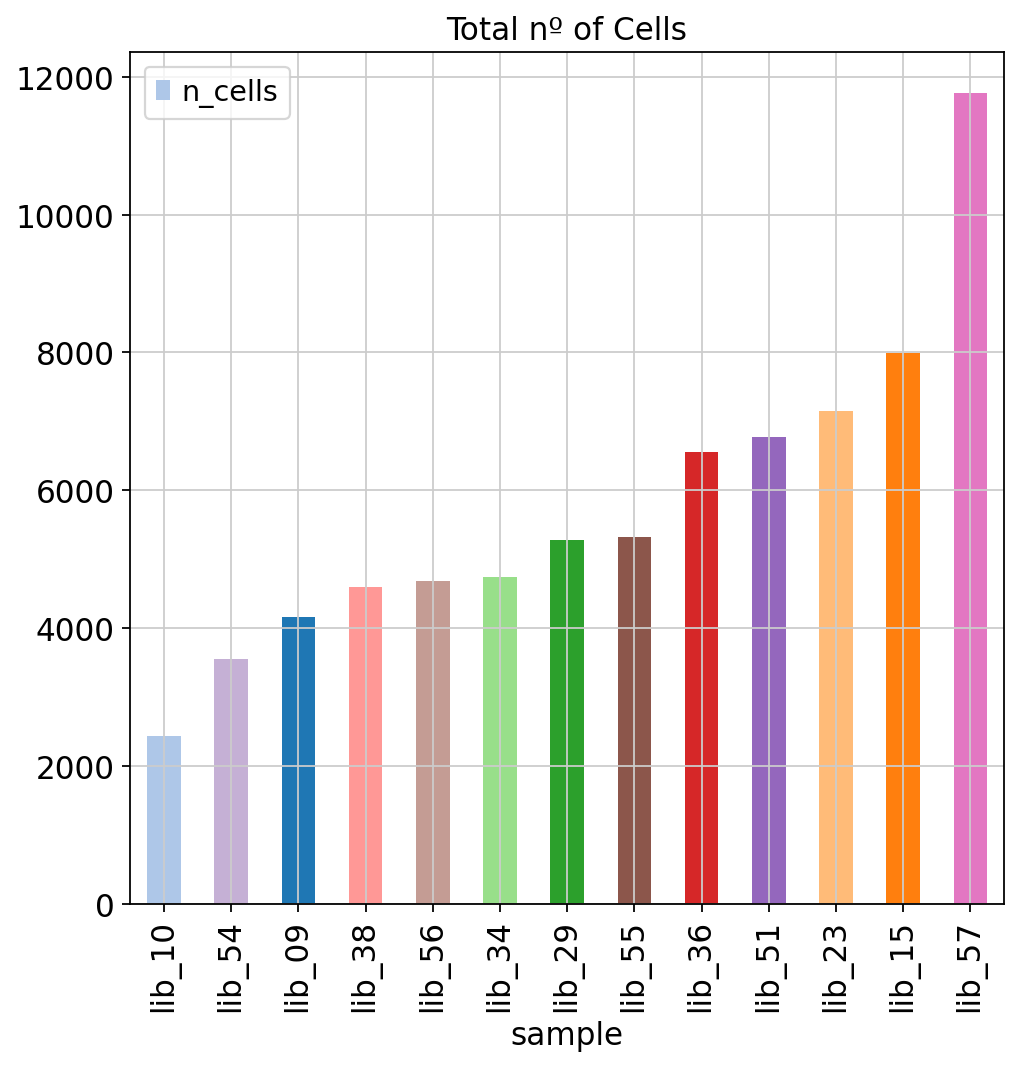

In [43]:
n_cells_histogram(adata)

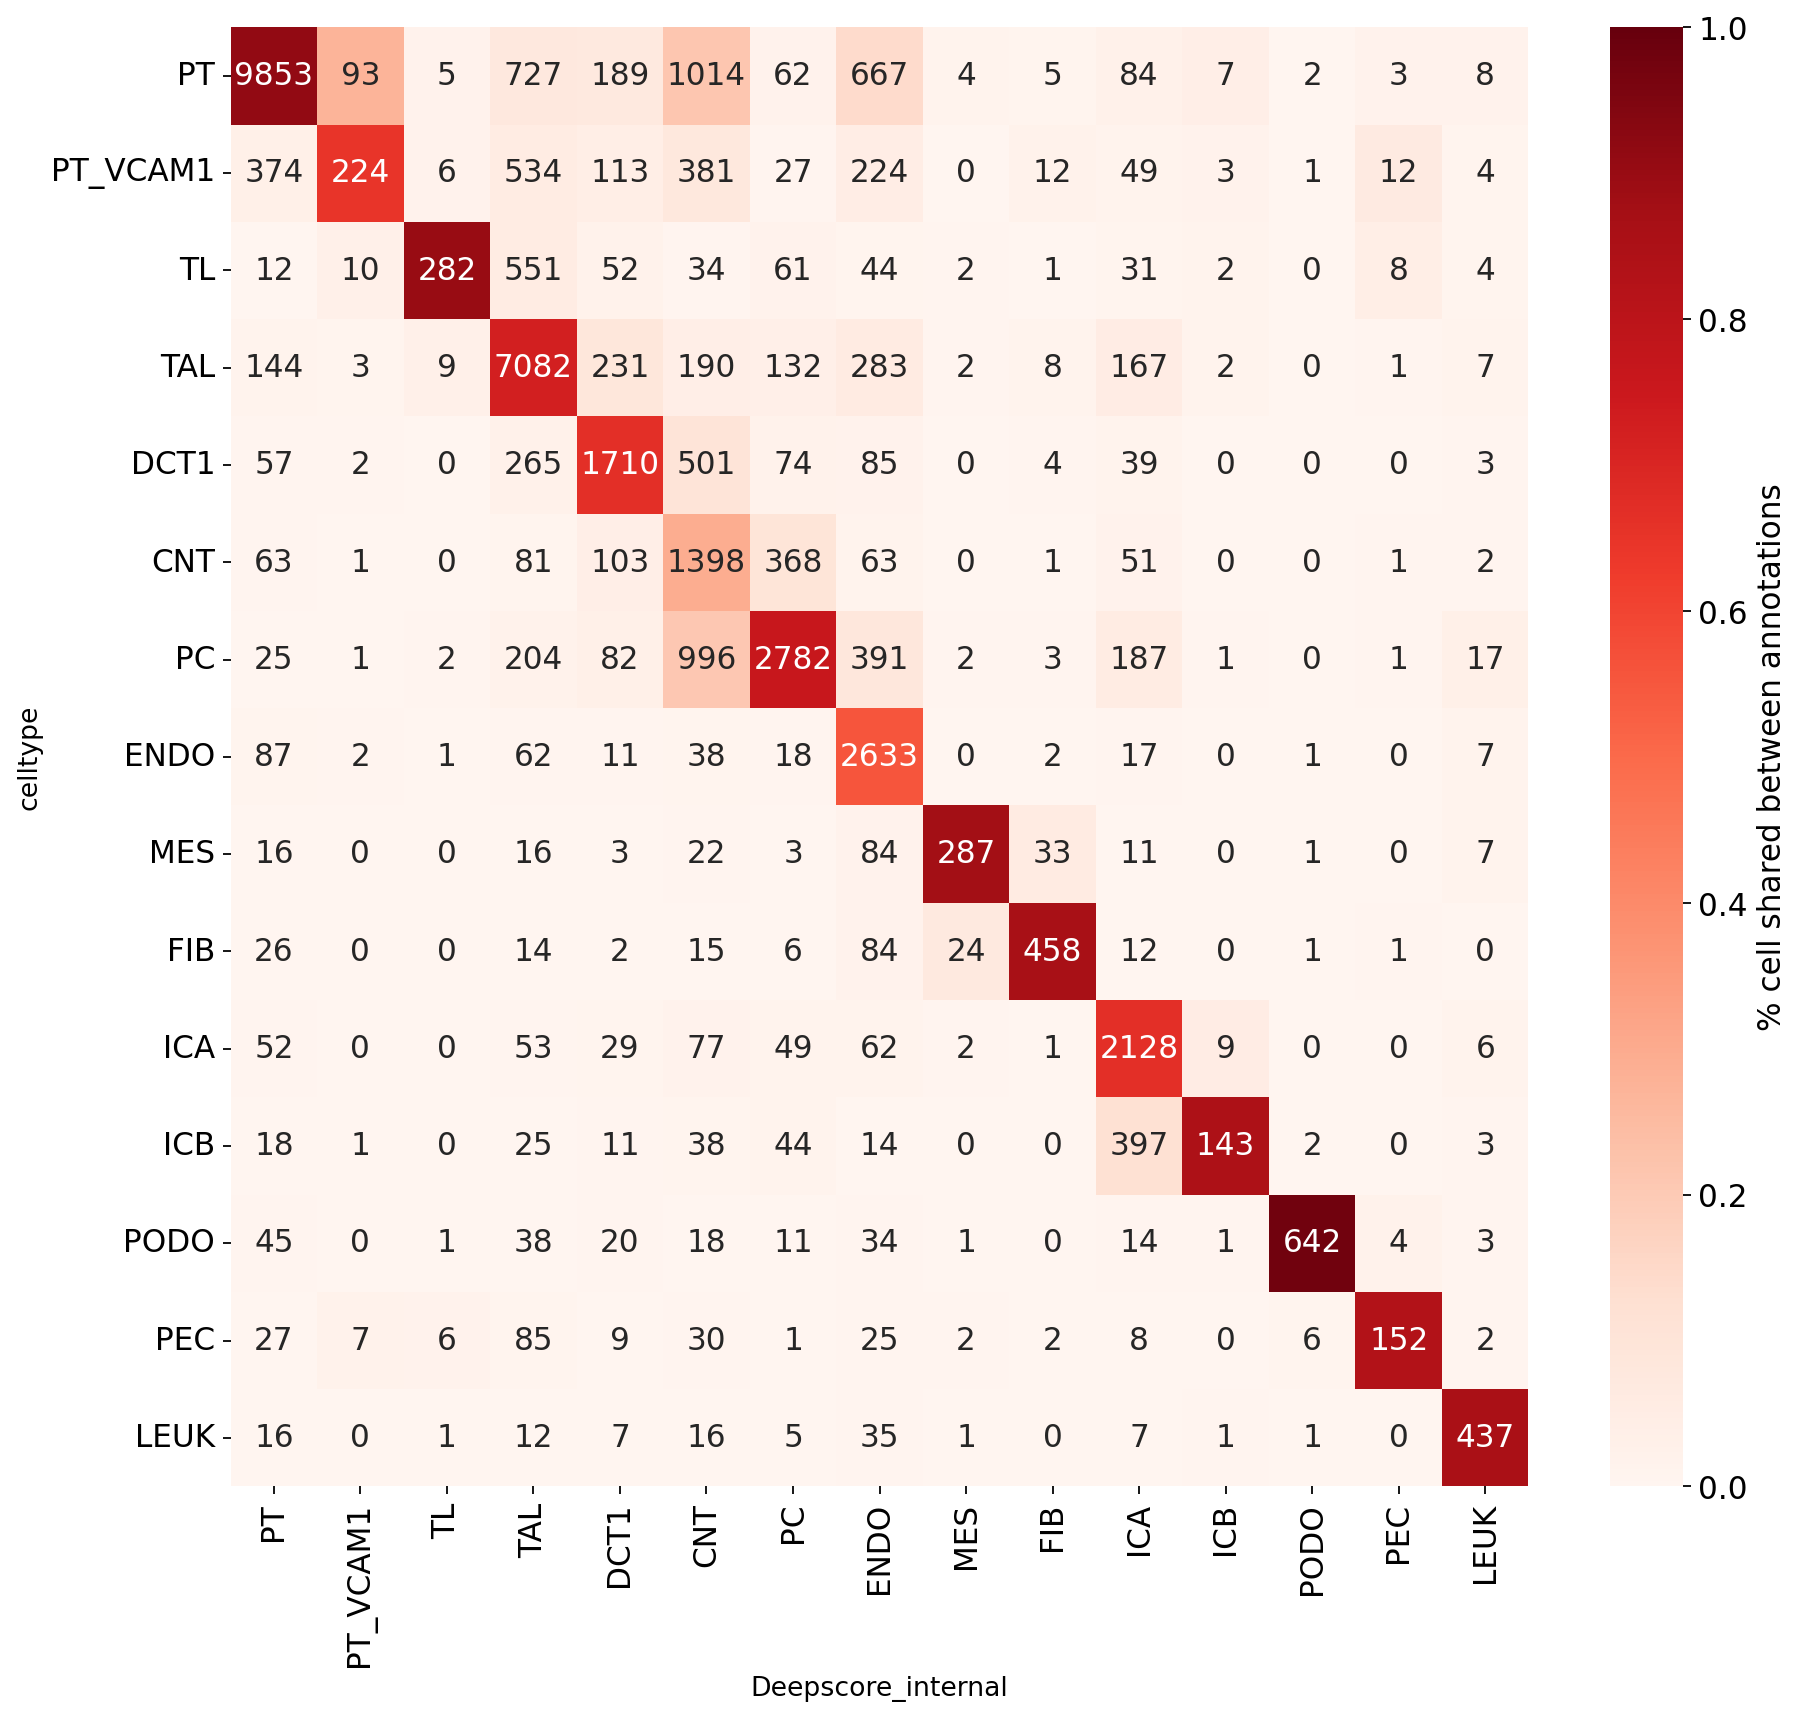

In [61]:
df = comparison_heatmap(adata, 'Deepscore_internal','celltype', annot=True, figsize=(13,12))

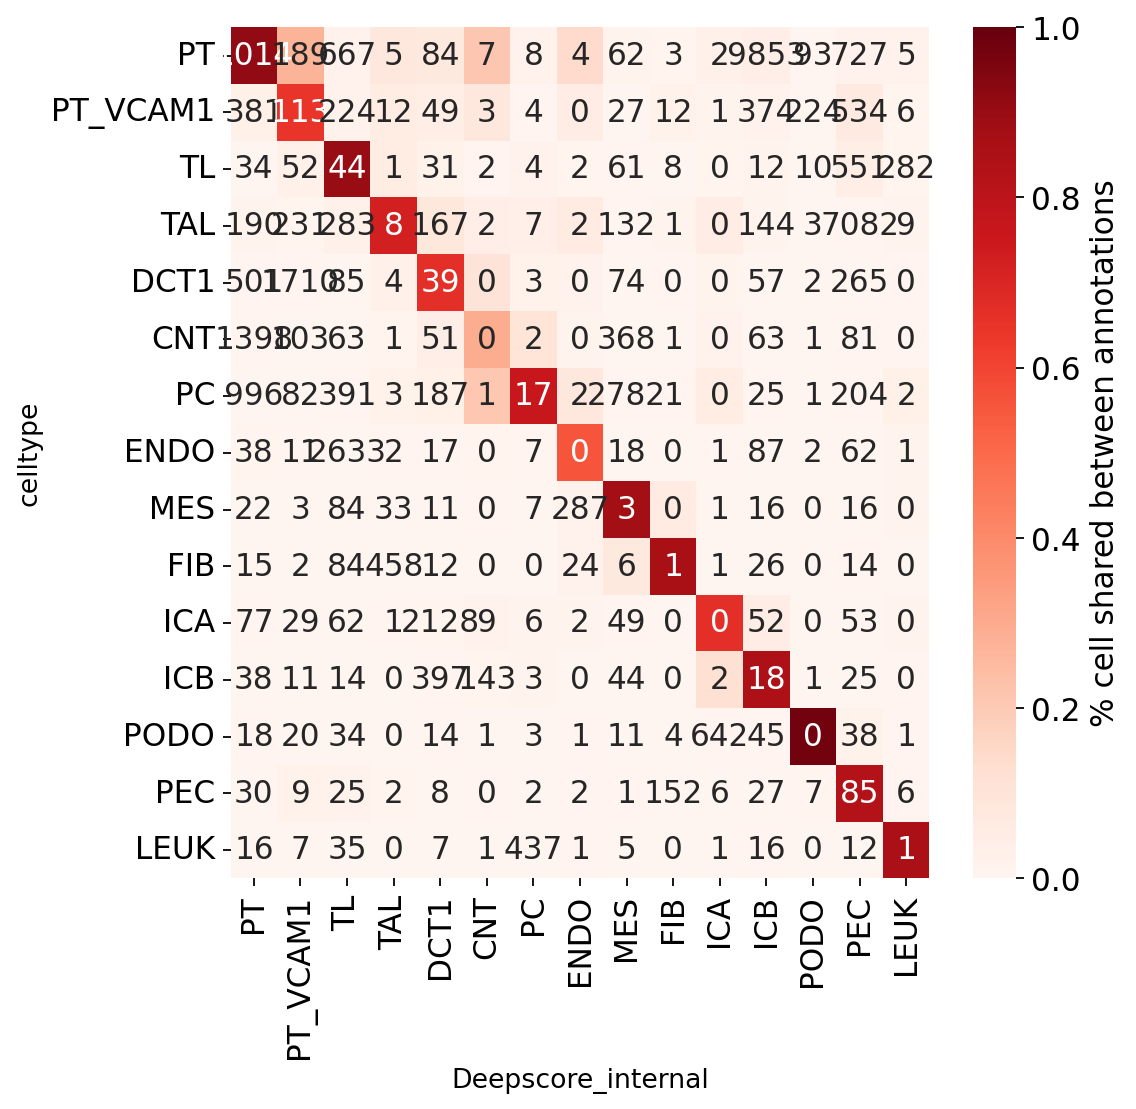

In [56]:
df = comparison_heatmap(adata, 'Deepscore_internal','celltype', annot=False)